# Negative Tone Data Generator

This notebook contains code for an MLP neural network that generates negatively toned data based on the dataset. Feature vectors are then made from the negatively toned data and generated data then saved into .csv files.

### Import Libraries

In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from gensim.models import Word2Vec
from nltk import regexp_tokenize, WordNetLemmatizer
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Input

In [3]:
df_raw = pd.read_csv('poem_sentiment.csv', header=None, index_col=0, names=['Text', 'Sentiment'])
df_raw

,Text,Sentiment
0,with pale blue berries. in these peaceful shad...,1.0
1,it flows so long as falls the rain,0.0
2,"and that is why, the lonesome day",-1.0
3,"when i peruse the conquered fame of heroes, an...",2.0
4,of inward strife for truth and liberty.,2.0
...,...,...
887,to his ears there came a murmur of far seas be...,0.0
888,"the one good man in the world who knows me, --",1.0
889,faint voices lifted shrill with pain,-1.0
890,"an', fust you knowed on, back come charles the...",0.0


In [4]:
negative = df_raw[df_raw['Sentiment'] < 0]
negative

,Text,Sentiment
2,"and that is why, the lonesome day",-1.0
8,and so on. then a worthless gaud or two,-1.0
17,sounded o'er earth and sea its blast of war,-1.0
37,"want and woe, which torture us",-1.0
39,an echo returned on the cold gray morn,-1.0
...,...,...
874,"in town, an' not the leanest runt",-1.0
883,by death's frequented ways,-1.0
885,rejection of his humanness,-1.0
889,faint voices lifted shrill with pain,-1.0


### Text Preprocessing

In [5]:
raw_text = negative['Text'].to_string(index=False)
raw_text[:1000]

"                 and that is why, the lonesome day\n           and so on. then a worthless gaud or two\n       sounded o'er earth and sea its blast of war\n                    want and woe, which torture us\n            an echo returned on the cold gray morn\n       while i, ... i built up follies like a wall\n          ah, what a pang of aching sharp surprise\n                 and the old swallow-haunted barns\n     the which she bearing home it burned her nest\n    the crown of sorrow on their heads, their loss\n               i lay and watched the lonely gloom;\n          a sceptremonstrous, winged, intolerable.\n while the rude winds blow off each shadowy crown.\n         but o, nevermore can we prison him tight.\n                 may meditate a whole youth's loss\n        when thee, the eyes of that harsh long ago\n        the foes inclosing, and his friend pursued\nand bow to dread inquisitor and worship lords o...\n        miles off, three dangerous miles, is home;\n      else,

In [6]:
# Remove all non-ASCII characters
processed_text = re.sub(r'[^\x00-\x7f]', r'', raw_text).lower()
processed_text[:1000]

"                 and that is why, the lonesome day\n           and so on. then a worthless gaud or two\n       sounded o'er earth and sea its blast of war\n                    want and woe, which torture us\n            an echo returned on the cold gray morn\n       while i, ... i built up follies like a wall\n          ah, what a pang of aching sharp surprise\n                 and the old swallow-haunted barns\n     the which she bearing home it burned her nest\n    the crown of sorrow on their heads, their loss\n               i lay and watched the lonely gloom;\n          a sceptremonstrous, winged, intolerable.\n while the rude winds blow off each shadowy crown.\n         but o, nevermore can we prison him tight.\n                 may meditate a whole youth's loss\n        when thee, the eyes of that harsh long ago\n        the foes inclosing, and his friend pursued\nand bow to dread inquisitor and worship lords o...\n        miles off, three dangerous miles, is home;\n      else,

### Tokenization

In [7]:
# Get word tokens from text
word_tokens = regexp_tokenize(processed_text, pattern=r'[^\S\r\n]+|[\.,:;!?()--_"]', gaps=True)
word_tokens = [val for values in map(re.compile('[^\t\n]+|[\t\n]').findall, word_tokens) for val in values]
print(f"Number of word tokens: {len(word_tokens)}")
word_tokens[:10]

Number of word tokens: 1266


['and', 'that', 'is', 'why', 'the', 'lonesome', 'day', '\n', 'and', 'so']

In [8]:
# Lemmatization done to make uncommon words more likely to be recognized by 
# Word2Vec model later when converting to feature vectors
lemmatizer = WordNetLemmatizer()
word_tokens = [lemmatizer.lemmatize(token) for token in word_tokens] # Lemmatize nouns
word_tokens = [lemmatizer.lemmatize(token, 'v') for token in word_tokens] # Lemmatize verbs

In [9]:
# Get unique word tokens from word tokens
unique_words = sorted(list(set(word_tokens)))
print(f"Number of unique word tokens: {len(unique_words)}")

Number of unique word tokens: 576


In [10]:
# Create vocabulary of word tokens
word_vocabulary = unique_words
word_vocabulary[:10]

['\n',
 "'",
 "'twas",
 'a',
 'accomplish',
 'ache',
 'add',
 'adulterate',
 'afar',
 'after']

### Create word-index mappings

In [11]:
# Create index-word mappings 
indices_words = dict((index, word) for index, word in enumerate(unique_words))
indices_words

{0: '\n',
 1: "'",
 2: "'twas",
 3: 'a',
 4: 'accomplish',
 5: 'ache',
 6: 'add',
 7: 'adulterate',
 8: 'afar',
 9: 'after',
 10: 'age',
 11: 'ago',
 12: 'ah',
 13: 'air',
 14: 'all',
 15: 'altar',
 16: 'always',
 17: 'among',
 18: 'an',
 19: "an'",
 20: 'and',
 21: 'angel',
 22: 'answer',
 23: 'anxious',
 24: 'around',
 25: 'arrow',
 26: 'ash',
 27: 'ask',
 28: 'at',
 29: 'augur',
 30: 'avenge',
 31: 'away',
 32: 'b',
 33: 'bad',
 34: 'barn',
 35: 'barrenly',
 36: 'bat',
 37: 'be',
 38: 'beam',
 39: 'bear',
 40: 'beat',
 41: 'because',
 42: 'become',
 43: 'bed',
 44: 'beguile',
 45: 'behold',
 46: 'bind',
 47: 'bitter',
 48: 'black',
 49: 'blankness',
 50: 'blast',
 51: 'bleed',
 52: 'blend',
 53: 'blight',
 54: 'blind',
 55: 'blindness',
 56: 'blood',
 57: 'blow',
 58: 'body',
 59: 'bow',
 60: 'brand',
 61: 'break',
 62: 'breast',
 63: 'briareus',
 64: 'build',
 65: 'burn',
 66: 'but',
 67: 'by',
 68: 'calumny',
 69: 'can',
 70: "captive's",
 71: 'change',
 72: 'child',
 73: 'claim',

In [12]:
# Create word-index mappings
word_indices = dict((word, index) for index, word in enumerate(unique_words))
word_indices

{'\n': 0,
 "'": 1,
 "'twas": 2,
 'a': 3,
 'accomplish': 4,
 'ache': 5,
 'add': 6,
 'adulterate': 7,
 'afar': 8,
 'after': 9,
 'age': 10,
 'ago': 11,
 'ah': 12,
 'air': 13,
 'all': 14,
 'altar': 15,
 'always': 16,
 'among': 17,
 'an': 18,
 "an'": 19,
 'and': 20,
 'angel': 21,
 'answer': 22,
 'anxious': 23,
 'around': 24,
 'arrow': 25,
 'ash': 26,
 'ask': 27,
 'at': 28,
 'augur': 29,
 'avenge': 30,
 'away': 31,
 'b': 32,
 'bad': 33,
 'barn': 34,
 'barrenly': 35,
 'bat': 36,
 'be': 37,
 'beam': 38,
 'bear': 39,
 'beat': 40,
 'because': 41,
 'become': 42,
 'bed': 43,
 'beguile': 44,
 'behold': 45,
 'bind': 46,
 'bitter': 47,
 'black': 48,
 'blankness': 49,
 'blast': 50,
 'bleed': 51,
 'blend': 52,
 'blight': 53,
 'blind': 54,
 'blindness': 55,
 'blood': 56,
 'blow': 57,
 'body': 58,
 'bow': 59,
 'brand': 60,
 'break': 61,
 'breast': 62,
 'briareus': 63,
 'build': 64,
 'burn': 65,
 'but': 66,
 'by': 67,
 'calumny': 68,
 'can': 69,
 "captive's": 70,
 'change': 71,
 'child': 72,
 'claim': 73,

### Create Blocks

In [13]:
# Create x (input): Split text into blocks, where each block has the same amount of words
# Create y (targets): For each x input, the y is the word that comes next
# The model should learn to predict y from the input x

block_size = 2
step = 1

x = []
y = []

for i in range(0, len(word_tokens) - block_size, step):
    x.append(word_tokens[i: i+block_size])
    y.append(word_tokens[i + block_size])

In [14]:
# Inspect x
x[:5]

[['and', 'that'],
 ['that', 'be'],
 ['be', 'why'],
 ['why', 'the'],
 ['the', 'lonesome']]

In [15]:
# Check number of blocks
len(x)

1264

### Create One-Hot Encoding

In [16]:
# Create one-hot encoding of x
x_encoded = []

for x_arr in x:
    x_ints = [word_indices[item] for item in x_arr]
    
    x_row = []
    for item in x_ints:
        x_vector = np.zeros(len(unique_words))
        x_vector[item] = 1
        x_row.append(x_vector)
        
    x_encoded.append(x_row)
    
x_encoded = np.array(x_encoded)

In [17]:
# Inspect y
y[:5]

['be', 'why', 'the', 'lonesome', 'day']

In [18]:
# Convert each word in y into their corresponding indices
y_ints = [word_indices[item] for item in y]
y_ints[:5]

[37, 550, 471, 268, 101]

In [19]:
# Create one-hot encoding of y
y_encoded = []

for item in y_ints:
    y_vector = np.zeros(len(unique_words))
    y_vector[item] = 1
    y_encoded.append(y_vector)

y_encoded = np.array(y_encoded)

### Model Configuration

In [20]:
class TextGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, block_size):
        super().__init__()

        self.embeddings = nn.Linear(input_dim, 2000)
        self.hidden = nn.Linear(2000, 1200)
        self.output = nn.Linear(1200, output_dim)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.sigmoid(self.embeddings(x))
        x = self.tanh(self.hidden(x))
        x = self.softmax(self.output(x))

        return x

In [21]:
# Get size of input for training the model
input_size = x_encoded[0].ravel().shape[0]
print(x_encoded[0].ravel().shape[0])

1152


In [22]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

# Create x and y PyTorch tensors
x = torch.tensor(x_encoded).float().to(device)
y = torch.tensor(y_encoded).float().to(device)

Performing torch operations on cpu device


In [23]:
# Instantiate model
model = TextGenerator(input_size, len(unique_words), block_size).to(device)

# Print model configuration
model

TextGenerator(
  (embeddings): Linear(in_features=1152, out_features=2000, bias=True)
  (hidden): Linear(in_features=2000, out_features=1200, bias=True)
  (output): Linear(in_features=1200, out_features=576, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [24]:
# Define model optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.000000001)
criterion = nn.CrossEntropyLoss()

### Create Dataset & DataLoader

In [25]:
# Create custom Dataset class
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.n_samples = len(x)
    
    def __getitem__(self, index):
        return self.x[index].ravel(), self.y[index]
    
    def __len__(self):
        return self.n_samples

In [26]:
# Create training dataset using custom Dataset class
training_ds = CustomDataset(x, y)

In [27]:
# Load training dataset into DataLoader
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(
    training_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

### Train Model

In [28]:
# Define function to train model
def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)

    ave_loss = 0
    count = 0 
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        predictions = model.forward(data)
        loss = loss_fn(predictions, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm loading bar
        loop.set_postfix(loss=loss.item())

        count += 1
        ave_loss += loss.item()
    
    ave_loss = ave_loss / count

    return ave_loss

In [29]:
# Train model
epochs = 2 # TODO: CHANGE TO 300 ON FINAL DATA; CURRENTLY 2 FOR TESTING PURPOSES
average_losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    ave_loss = train_fn(train_loader, model, optimizer, criterion, device)
    
    print("Ave Loss: {}".format(ave_loss))
    average_losses.append(ave_loss)

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████| 127/127 [00:07<00:00, 16.56it/s, loss=6.36]


Ave Loss: 6.356144792451634
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████| 127/127 [00:07<00:00, 16.53it/s, loss=6.36]

Ave Loss: 6.356144623493585


### Generate Text

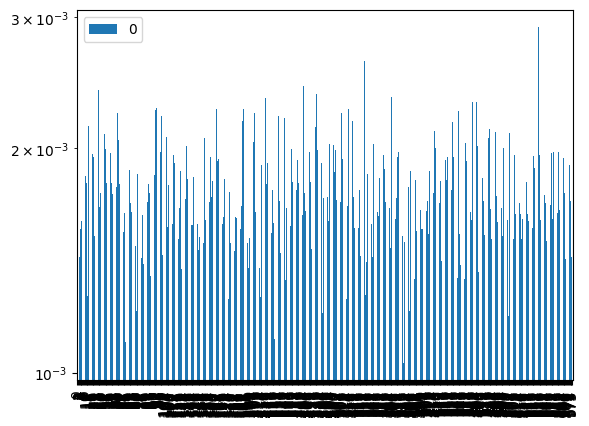

In [30]:
# Inspect probability distribution of word tokens
import matplotlib.pyplot as plt
import pandas as pd
random.seed(2)

phrase = [indices_words[random.randint(0, len(unique_words))], indices_words[random.randint(0, len(unique_words))]]
x_ints = [word_indices[item] for item in phrase]
x_vector = []

for item in x_ints:
    x_item = np.zeros(len(unique_words))
    x_item[item] = 1
    x_vector.append(x_item)

initial_input = torch.tensor([np.array([x_vector]).ravel()]).to(dtype=torch.float32)
output = model(initial_input)[0].detach().cpu().numpy()

df = pd.DataFrame(output)
df.plot.bar()
plt.yscale("log")
plt.show()

In [31]:
# Generate text sample from model output
word_count = 100
text = []
paragraph_count = 5

# Length of phrase should be same as block_size
word1, word2 = indices_words[random.randint(0, len(unique_words))], indices_words[random.randint(0, len(unique_words))]

for p in range(paragraph_count):
    text.append([])
    
    for i in range(word_count):
        phrase = [word1, word2]
        x_ints = [word_indices[item] for item in phrase]
        x_vector = []

        for item in x_ints:
            x_item = np.zeros(len(unique_words))
            x_item[item] = 1
            x_vector.append(x_item)

        initial_input = torch.tensor([np.array([x_vector]).ravel()]).float().to(device)

        output = model(initial_input)[0].detach().cpu().numpy()

        # Workaround to fix occasional sum(pvals[:-1]) > 1.0  bug from implicit casting in np.random.multinomial 
        output = output.astype(float)
        output /= output.sum()

        index = np.where(np.random.multinomial(1, output) == 1)[0][0]
        word3 = indices_words[index]
        text[p].append(word3)

        # Use generated word from this run as seed for next run
        word1, word2 = word2, word3

In [32]:
for p in range(paragraph_count):
    print(f"Generated Paragraph {p}:")
    print(' '.join(text[p]))
    print('\n')

Generated Paragraph 0:
expire lonely in sceptremonstrous sufferd out when it sweep because youth's trouble people you cruell wild mourn wrong pain wander stifle o'er hi scarlet homesick child task watch o day fill the root voice oblivion's know fool time's though bleed stifle thou bleed goad star cou hang obliterate more want meditate o'er age task live treatin fight monster with forelaid dread child war within fool selfishness curse old arrow smile poor behold lift hang cou of or nerve make such hearthstone deplore enemy humanness pain high slave gallic hang wall tinkle b at now glance sorrow's ago oblivion's beguile twilight


Generated Paragraph 1:
threaten may into shall flight strangle solemn slumber stifle him life how mankind warn serious daily here surprise steerd more at sceptremonstrous arrow for trail maidenhead sharp voice men frequent lone brand fire pity break mood string old wild him cruell ache force surprise hell scare forelaid selfishness treatin until fool wreck stif

### Create Feature Vectors from Input Data

In [33]:
sentences = []

# Tokenize by line
for index, row in negative.iterrows():
    tokenized_row = row['Text'].split(' ')
    
    # Preprocess using the same settings as preprocessing done before training model
    tokenized_row = regexp_tokenize(' '.join(tokenized_row), pattern=r'[^\S\r]+|[\.,;!?()--_"]', gaps=True)
    tokenized_row = [lemmatizer.lemmatize(token) for token in tokenized_row] # Lemmatize nouns
    tokenized_row = [lemmatizer.lemmatize(token, 'v') for token in tokenized_row] # Lemmatize verbs
    
    sentences.append(tokenized_row)
    
sentences

[['and', 'that', 'be', 'why', 'the', 'lonesome', 'day'],
 ['and', 'so', 'on', 'then', 'a', 'worthless', 'gaud', 'or', 'two'],
 ['sound', "o'er", 'earth', 'and', 'sea', 'it', 'blast', 'of', 'war'],
 ['want', 'and', 'woe', 'which', 'torture', 'u'],
 ['an', 'echo', 'return', 'on', 'the', 'cold', 'gray', 'morn'],
 ['while', 'i', 'i', 'build', 'up', 'folly', 'like', 'a', 'wall'],
 ['ah', 'what', 'a', 'pang', 'of', 'ache', 'sharp', 'surprise'],
 ['and', 'the', 'old', 'swallow', 'haunt', 'barn'],
 ['the', 'which', 'she', 'bear', 'home', 'it', 'burn', 'her', 'nest'],
 ['the', 'crown', 'of', 'sorrow', 'on', 'their', 'head', 'their', 'loss'],
 ['i', 'lay', 'and', 'watch', 'the', 'lonely', 'gloom'],
 ['a', 'sceptremonstrous', 'wing', 'intolerable'],
 ['while', 'the', 'rude', 'wind', 'blow', 'off', 'each', 'shadowy', 'crown'],
 ['but', 'o', 'nevermore', 'can', 'we', 'prison', 'him', 'tight'],
 ['may', 'meditate', 'a', 'whole', "youth's", 'loss'],
 ['when', 'thee', 'the', 'eye', 'of', 'that', 'hars

In [34]:
vector_size = 100
w2v_model = Word2Vec(sentences, vector_size=vector_size, min_count=1)

In [35]:
vocab = w2v_model.wv.index_to_key
vocab_length = len(vocab)

print(f'Vocabulary Size: {format(vocab_length)}')

Vocabulary Size: 588


In [36]:
vocab

['the',
 'and',
 'a',
 'of',
 'be',
 'to',
 'in',
 'his',
 'with',
 'it',
 'that',
 'but',
 'on',
 'by',
 'their',
 'i',
 'which',
 'thy',
 'from',
 'when',
 'for',
 'eye',
 'come',
 'he',
 'dead',
 'while',
 'see',
 'like',
 'at',
 'make',
 'world',
 'heart',
 'tear',
 'your',
 'pain',
 'her',
 'all',
 'have',
 'not',
 'how',
 'seem',
 'rude',
 'loss',
 'fear',
 'heavy',
 'dark',
 'hang',
 'will',
 'though',
 'set',
 'would',
 'madness',
 'lie',
 'cry',
 'no',
 'sea',
 'cold',
 "o'er",
 'frown',
 'strange',
 'echo',
 'till',
 'day',
 'what',
 'they',
 'flame',
 'my',
 'water',
 'torture',
 'woe',
 'crush',
 'always',
 'cloudy',
 'shadow',
 'shrill',
 'course',
 'claim',
 'where',
 'sad',
 'fall',
 'leave',
 'fire',
 'blood',
 'there',
 'death',
 'those',
 'people',
 'burn',
 'leaf',
 'me',
 'hate',
 'root',
 'melancholy',
 'our',
 'danger',
 'angel',
 'word',
 'wa',
 'then',
 'steal',
 'or',
 'throw',
 'this',
 'sound',
 'you',
 'vain',
 'nerve',
 'mine',
 'away',
 'earth',
 'sleep',


In [37]:
w2v_model.wv.similarity('he', 'his')

0.09424457

In [38]:
def sentence_to_vector_averaging(sentence, model):
    embeddings = [model.wv[word] for word in sentence if word in vocab]
    
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(embeddings, axis=0)

In [39]:
features = []

for sentence in sentences:
    features.append(sentence_to_vector_averaging(sentence, w2v_model))

In [40]:
columns = [f'x{i}' for i in range(w2v_model.vector_size)]

df_text = pd.DataFrame(features, columns=columns)

In [41]:
df_text['y'] = [float(x) for x in negative['Sentiment']]
df_text

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.002635,0.002073,0.001640,-0.001092,0.000702,-0.004121,0.003429,0.003238,-0.001603,-0.004441,...,0.001299,0.003675,-0.000237,0.001576,-0.000502,0.004003,0.000927,0.000313,0.002844,-1.0
1,-0.001567,0.001821,0.000933,0.000537,0.001855,-0.002611,-0.001741,0.004161,-0.001008,0.001186,...,-0.002191,0.002025,-0.002866,0.001479,-0.000595,0.002542,0.000635,0.001484,0.001236,-1.0
2,-0.003221,0.001805,0.004012,0.000697,0.002601,-0.003450,0.001961,0.002532,-0.005104,-0.005206,...,0.003314,-0.001148,-0.001469,0.002458,0.001178,0.001007,-0.001765,0.001462,-0.001077,-1.0
3,0.001055,0.000047,0.003790,-0.002903,0.002489,-0.002660,0.001892,0.002954,-0.004730,-0.000013,...,0.002590,0.000015,-0.003518,-0.002318,0.004180,-0.001475,-0.002432,-0.002021,0.003180,-1.0
4,0.002718,0.000757,0.003443,0.002107,-0.000521,0.000391,0.002879,0.008274,0.001731,-0.000097,...,0.000062,-0.000856,0.000222,0.001366,0.001535,-0.003517,0.000665,-0.000013,0.000907,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,-0.000828,0.001477,0.002940,0.000595,0.001523,-0.000404,0.000284,0.002123,-0.000700,-0.000375,...,-0.001745,-0.001104,-0.001014,0.001452,0.001703,0.001786,-0.005261,-0.000980,0.004666,-1.0
151,0.000383,-0.000077,-0.002621,0.000914,-0.005285,0.002970,0.001621,-0.003106,-0.005056,-0.005158,...,-0.000337,0.002719,-0.000342,-0.002319,-0.001741,0.001024,-0.004805,0.001432,0.001137,-1.0
152,0.002676,-0.000389,0.002747,0.002768,-0.001215,0.000844,0.000177,0.002195,-0.000846,-0.004233,...,0.000097,-0.005863,-0.000197,0.004185,0.002983,-0.003276,-0.003367,-0.002619,-0.001965,-1.0
153,-0.005223,0.001633,-0.001118,0.001054,-0.001881,-0.001437,-0.002837,0.000140,0.002687,0.000493,...,-0.001411,-0.000660,-0.002264,0.000308,0.004514,-0.002617,0.000905,-0.001918,-0.001979,-1.0


In [42]:
# Save feature vectors as csv
df_text.to_csv('negative.csv')

### Create Feature Vectors from Generated Data

In [43]:
vector_size = 100
w2v_model = Word2Vec(text, vector_size=vector_size, min_count=1)

In [44]:
vocab = w2v_model.wv.index_to_key
vocab_length = len(vocab)

print(f'Vocabulary Size: {format(vocab_length)}')

Vocabulary Size: 334


In [45]:
vocab

['sceptremonstrous',
 'because',
 'meditate',
 'solemn',
 'wild',
 'hi',
 'murmur',
 'blend',
 "oblivion's",
 'though',
 'selfishness',
 'burn',
 'bleed',
 'thou',
 'day',
 'sad',
 'wilt',
 'child',
 'mood',
 'daily',
 'with',
 'hang',
 'stifle',
 'none',
 'treatin',
 'trail',
 'glance',
 'it',
 'steerd',
 'forelaid',
 'people',
 'air',
 'soft',
 'cruell',
 'here',
 'shadowy',
 'fool',
 'serious',
 'surprise',
 'pursue',
 'warn',
 'into',
 'b',
 'at',
 'now',
 "sorrow's",
 'twilight',
 'night',
 'flight',
 'be',
 'run',
 'teach',
 "e'en",
 'three',
 'lap',
 'him',
 'land',
 'pity',
 'darkness',
 'melt',
 'some',
 'crush',
 'tire',
 'rave',
 'wheeze',
 'seek',
 'enough',
 'if',
 'ill',
 'spake',
 'visual',
 'dwell',
 'to',
 'kneel',
 'guard',
 'not',
 'priest',
 'wreck',
 'until',
 'off',
 'mission',
 'thunder',
 'cry',
 'suicide',
 'gallic',
 'bow',
 'cough',
 'frequent',
 'sharp',
 'tinkle',
 'smother',
 'pain',
 'pallid',
 'smile',
 'arrow',
 'old',
 'voice',
 'curse',
 'wander',
 'f

In [46]:
vectors = [w2v_model.wv[word] for word in vocab]
len(vectors[0])

100

In [47]:
def sentence_to_vector_averaging(sentence, model):
    embeddings = [model.wv[word] for word in sentence if word in vocab]
    
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(embeddings, axis=0)

In [48]:
features = []

for sentence in text:
    features.append(sentence_to_vector_averaging(sentence, w2v_model))

In [49]:
columns = [f'x{i}' for i in range(w2v_model.vector_size)]

df_text = pd.DataFrame(features, columns=columns)

In [50]:
df_text['y'] = [-1] * len(df_text)
df_text

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.000776,0.001361,-0.000192,0.000681,-0.000554,-0.000357,0.000794,0.001015,-0.000565,0.000392,...,0.000416,-0.000064,0.000291,0.001552,0.000335,0.000845,0.000235,-0.000125,-0.000189,-1
1,-0.000652,0.000058,-0.000384,-0.000273,-0.000361,-0.001130,0.000236,0.001197,-0.000240,-0.000579,...,0.000191,-0.000423,-0.000321,0.001095,0.000751,0.000384,-0.002180,0.000869,-0.000138,-1
2,0.000413,-0.000185,0.000998,-0.000750,0.000465,-0.000152,0.000588,0.000686,-0.000361,0.000526,...,0.000232,-0.000102,-0.000182,0.000015,-0.000005,-0.000407,-0.000881,-0.000101,0.000692,-1
3,-0.000599,-0.000564,-0.000446,0.000030,0.000071,-0.001340,-0.000034,0.000762,0.000327,-0.000294,...,0.001293,0.000205,-0.000705,0.001102,0.000650,0.000461,0.000189,0.000653,-0.001019,-1
4,0.001005,0.000582,0.000245,0.000383,0.001022,-0.000431,0.000158,0.001489,-0.000992,-0.001022,...,0.000247,0.000208,0.001172,-0.000425,0.000884,0.000185,0.000553,0.000148,-0.000100,-1


In [51]:
# Save feature vectors as csv
df_text.to_csv('negative_generated.csv')